# 07 PyTorch Experiment Tracking.

Machine Leaning is very experimental.

In order to figure out which experiments are worth pursuing, it's import to know what **doesn't** work so we can focus on what **does** work.


In [1]:
import torch
import torchvision

torch.__version__ , torchvision.__version__

('2.0.0', '0.15.0')

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Set seeds
def set_seeds(seed: int=42):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

## 1. Get Data

want to get pizza, steak and sushi images.

So we can run experiments building FoodVision Mini and see which model performs best.

In [4]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source: str,
                 destination: str,
                 remove_source: bool=True)-> Path:
    """
    Download a zipped dataset from source and unzips to destination.
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination
    
    # If the image folder doesn;t exist, create
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory alrady exist, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creatig one...")
        image_path.mkdir(exist_ok=True, parents=True)
        
        # Download target data
        target_file = Path(source).name
        with open(data_path/destination, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)
            
        # Unzip target file
        with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
            print(f"[INFO] unzippping {target_file} data...")
            zip_ref.extractall(image_path)
            
        # Remove .zip file
        if remove_source:
            os.remove(data_path/target_file)
            
            
    return image_path

In [5]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination='pizza_steak_sushi')

image_path


[INFO] data\pizza_steak_sushi directory alrady exist, skipping download.


WindowsPath('data/pizza_steak_sushi')

## 2. Create Datasets and Dataloaders


### 2.1 Create Dataloaders with manual transforms

In [6]:
# Setup directory
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
from torchvision import transforms

# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Create transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manually Created Transforms: {manual_transforms}")


# Create Dataloaders
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

Manually Created Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x14f89a5fa30>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create Dataloaders with automatic transforms

In [8]:
# Setup dirs 
train_dir = image_path /"train"
test_dir = image_path / "test"

# Setup pre-trained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights 
automatic_transforms = weights.transforms()
print(f"Automatically created trasnforms: {automatic_transforms}")

# Getting dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=automatic_transforms,
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

Automatically created trasnforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x14f89a5ffa0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [9]:
# Downloading weights of EfficientNet_B0 weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Passing weights to the architecture of efficientnet B0
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [10]:
# Freeze all base layers by setting their requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
from torch import nn
set_seeds()

# Change the classifier head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
             out_features=len(class_names))
).to(device)

In [12]:
from torchinfo import summary

summary(model=model, 
        verbose=0,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train a single model and track results (TENSORBOARD)

We are going to use PyTorchs `SummaryWriter`

In [13]:
# Define a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)

In [14]:
# Setup a SummaryWriter
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

writer

In [15]:
from going_modular.engine import train_step, test_step
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  
  # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### New: Experiment Tracking ###
        # See summary writer documentation
        writer.add_scalars(main_tag = "Loss",
                          tag_scalar_dict={"train_loss": train_loss,
                                          "test_loss": test_loss},
                          global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                          tag_scalar_dict={"train_acc": train_acc,
                                          "test_acc": test_acc},
                          global_step=epoch)
        writer.add_graph(model=model,
                        input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    # Close the writer
    writer.close()

    # Return the filled results at the end of the epochs
    return results


In [16]:
# Train model
# Note: not using engine.train() since we upadted the train function above
set_seeds()
results = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
                optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=5,
               device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8966 | train_acc: 0.6562 | test_loss: 0.7840 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8045 | train_acc: 0.7422 | test_loss: 0.6716 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6786 | train_acc: 0.7305 | test_loss: 0.6697 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.7066 | train_acc: 0.7188 | test_loss: 0.6737 | test_acc: 0.7737


In [17]:
results

{'train_loss': [1.0929144099354744,
  0.8965976014733315,
  0.8044742718338966,
  0.6786275953054428,
  0.7066026479005814],
 'train_acc': [0.40234375, 0.65625, 0.7421875, 0.73046875, 0.71875],
 'test_loss': [0.9125327269236246,
  0.7839517196019491,
  0.67161891857783,
  0.6697317957878113,
  0.6737382610638937],
 'test_acc': [0.5501893939393939,
  0.8560606060606061,
  0.8863636363636364,
  0.8257575757575758,
  0.7736742424242425]}

## 5. View our model's results with Tensorboard

There are few ways: 
https://www.learnpytorch.io/07_pytorch_experiment_tracking/#5-view-our-models-results-in-tensorboard

In [18]:
# Let's view our experiments from within the notebook

%load_ext tensorboard
%tensorboard --logdir runs

## 6. Create a function to prepare a `SummaryWriter()` instance

By default our `SummaryWriter()` class saves to `log_dir`.

How about if we wanted to save different experiments to different folders?

In essence, one experiment = one folder.

For example, we'd like to track:
* Experiment data/timestamp
* Experiment name
* Model Name
* Extra - is there anything else that shiould be tracked?

Let's create a function to create a `SummaryWriter()` instance to take all of these into account.

So ideally we end up tracking experiments to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [19]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str=None):
    """
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory.
    """
    from datetime import datetime
    import os
    
    # Get timestamp of current data in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        #Create log directory path
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
    
    print(f"[INFO] Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [20]:
expample_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra = "5_epochs")

expample_writer

[INFO] Created SummaryWriter saving to runs\2023-05-26\data_10_percent\effnetb0\5_epochs


### 6.1 Update `train()` function to include a `writer` parameter

In [21]:

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  
  # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        
        if writer:
            ### New: Experiment Tracking ###
            # See summary writer documentation
            writer.add_scalars(main_tag = "Loss",
                              tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                              tag_scalar_dict={"train_acc": train_acc,
                                              "test_acc": test_acc},
                              global_step=epoch)
            writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))

            # Close the writer
            writer.close()
        else:
            pass

    # Return the filled results at the end of the epochs
    return results


## 7. Setting up a series of modelling experiments

* Setup 2x modelling experiments with effnetb0, pizza_steak_sushi data. One model with 5 epochs and other model with 10 epochs. 

### 7.1 What kind of experiments should you run?

The number of machine learning experiments you can run, is like the number of different models you can build.... almost limitless.

You can test everything...

So what should you test?
* Check the number of epochs
* Change the number of hidden layers
* Change the amount of data
* Change the learning rate
* Try different kinds of data augmentation
* Choose a different model architecture

This is why transfer learning is so powerful, because it's a working model that you can apply to your own problem.

### 7.2 What experiments we going to run?

We are going to turn 3 dials here:
1. Model size - EfficientB0 vs EfficientB2
2. Dataset size -  10% to 20%
3. Training Time - 5 epochs vs 10 epochs

To begin, we're stil keeping things relatively small so that our experiments run quickly.

Our goal: A model that is well performing but still small enough to run on a mobile or web browser.

If you had infinite compute + time, you should always choose biggest model and dataset

<img src="Experiment_Tracking -1.png">

### 7.3 Download Different Dataset

We want two datasets:
1. Pizza, Steak, Sushi 10% - https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
2. Pizza, Steak, Sushi 20% - https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip

Created using this code -https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

In [22]:
# Download 10 percent and 20 percent datasets

data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                    destination='pizza_steak_sushi')

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination='pizza_steak_sushi_20_percent')

[INFO] data\pizza_steak_sushi directory alrady exist, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory alrady exist, skipping download.


### 7.4 Transform Datasets and Create DataLoaders

We'll need to transform our data for efficientnet architecture:
1. Resize to (224,224)
2. Make sure tensor values are between [0,1]
3. Normalize the image so they have same image distribution.

In [23]:
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# We will keep single test dataset
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [24]:
from torchvision import transforms

# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

In [25]:
BATCH_SIZE = 32

# Creating 10% Training and test dataloadeers
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                         test_dir=test_dir,
                                                                                         transform=simple_transform,
                                                                                         batch_size=BATCH_SIZE)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                         test_dir=test_dir,
                                                                                         transform=simple_transform,
                                                                                         batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in test data: {len(test_dataloader)}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in test data: 3


### 7.5 Create feature extractor models

We want two functions:
1. Create a `torchvision.models.efficientnet_b0()` feature extractor with a frozen base layers and a custom classfier head.
2. Do the same for `torchvision.models.efficientnet_b2()`

In [26]:
import torchvision

# Create an EffnetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to C:\Users\HIMANSHU GOSWAMI/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-bcdf34b7.pth
100%|█████████████████████████████████████████████████████████████████████████████| 35.2M/35.2M [00:02<00:00, 12.6MB/s]


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [27]:
from torchinfo import summary

summary(model=effnetb2, 
        verbose=0,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [30]:
from torch import nn

OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)
    
    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Change the classifier
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280,
                 out_features=OUT_FEATURES)
    ).to(device)
    
    # Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created a new {model.name} model...")
    
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Change the classifier
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                 out_features=OUT_FEATURES)
    ).to(device)
    
    # Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created a new {model.name} model...")
    
    return model


In [32]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()


[INFO] Created a new effnetb2 model...
[INFO] Created a new effnetb0 model...


In [33]:

summary(model=created_model_test_effnetb0, 
        verbose=0,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [34]:

summary(model=created_model_test_effnetb2, 
        verbose=0,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 7.6 Create experiments and set up training code

In [35]:
# Create epoch list
num_epochs=[5, 10]

# Create models list (need to create a new model for each experiment)
models = ['effnetb0', 'effnetb2']

# Create a DataLoaders dictionairy
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                    "data_20_percent": train_dataloader_20_percent}

In [39]:
device

'cuda'

In [41]:
%%time
from going_modular.utils import save_model

# Set seeds
set_seeds()

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        #Loop through each model name and create a new instance
        for model_name in models:
            
            # Print out info
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Epochs: {epochs}")
            
            # Select and create the model
            if model_name == "effnetb0":
                model = create_effnetb0().to(device)
            else:
                model = create_effnetb2().to(device)
                
            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(),
                                        lr=0.001)
            
            # Train target model with target dataloader and track experimment
            # Note: Using train() rather than engine.train()
            train(model=model,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 epochs=epochs,
                 device=device,
                 writer=create_writer(experiment_name=dataloader_name,
                                     model_name=model_name,
                                     extra=f"{epochs}_epochs"))
            
            # Save the model to a file so we can import it later if need be
            save_filepath = f"08_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                      target_dir="models",
                      model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Epochs: 5
[INFO] Created a new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2023-05-26\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0433 | train_acc: 0.4805 | test_loss: 0.9281 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9402 | train_acc: 0.5508 | test_loss: 0.8345 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8244 | train_acc: 0.6953 | test_loss: 0.7291 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7030 | train_acc: 0.7773 | test_loss: 0.6176 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6150 | train_acc: 0.8867 | test_loss: 0.5828 | test_acc: 0.8864
[INFO] Saving model to: models\08_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Epochs: 5
[INFO] Created a new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2023-05-26\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0861 | train_acc: 0.4023 | test_loss: 0.9619 | test_acc: 0.6903
Epoch: 2 | train_loss: 0.8960 | train_acc: 0.6250 | test_loss: 0.9030 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8457 | train_acc: 0.6641 | test_loss: 0.8035 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7026 | train_acc: 0.8516 | test_loss: 0.6921 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.7004 | train_acc: 0.7422 | test_loss: 0.6509 | test_acc: 0.8968
[INFO] Saving model to: models\08_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Epochs: 10
[INFO] Created a new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2023-05-26\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0433 | train_acc: 0.4805 | test_loss: 0.9281 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9402 | train_acc: 0.5508 | test_loss: 0.8345 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8244 | train_acc: 0.6953 | test_loss: 0.7291 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7030 | train_acc: 0.7773 | test_loss: 0.6176 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6150 | train_acc: 0.8867 | test_loss: 0.5828 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5431 | train_acc: 0.8750 | test_loss: 0.5942 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.6384 | train_acc: 0.7109 | test_loss: 0.5933 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5076 | train_acc: 0.8008 | test_loss: 0.5381 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4689 | train_acc: 0.9141 | test_loss: 0.5317 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.5795 | train_acc: 0.7344 | test_loss: 0.4906 | test_acc: 0.8759
[INFO] Saving model to: models\08_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0861 | train_acc: 0.4023 | test_loss: 0.9619 | test_acc: 0.6903
Epoch: 2 | train_loss: 0.8960 | train_acc: 0.6250 | test_loss: 0.9030 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8457 | train_acc: 0.6641 | test_loss: 0.8035 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7026 | train_acc: 0.8516 | test_loss: 0.6921 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.7004 | train_acc: 0.7422 | test_loss: 0.6509 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5988 | train_acc: 0.8984 | test_loss: 0.6597 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.6206 | train_acc: 0.8086 | test_loss: 0.6037 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.5340 | train_acc: 0.8164 | test_loss: 0.6002 | test_acc: 0.8570
Epoch: 9 | train_loss: 0.5031 | train_acc: 0.9258 | test_loss: 0.5605 | test_acc: 0.8570
Epoch: 10 | train_loss: 0.5308 | train_acc: 0.8008 | test_loss: 0.5461 | test_acc: 0.8977
[INFO] Saving model to: models\08_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9644 | train_acc: 0.5938 | test_loss: 0.6673 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.6941 | train_acc: 0.7833 | test_loss: 0.5834 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5817 | train_acc: 0.8313 | test_loss: 0.5025 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.4582 | train_acc: 0.8917 | test_loss: 0.4186 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4519 | train_acc: 0.8604 | test_loss: 0.3827 | test_acc: 0.9280
[INFO] Saving model to: models\08_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Epochs: 5
[INFO] Created a new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2023-05-26\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9883 | train_acc: 0.5271 | test_loss: 0.7821 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7125 | train_acc: 0.8250 | test_loss: 0.6504 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5772 | train_acc: 0.8917 | test_loss: 0.5522 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5209 | train_acc: 0.8583 | test_loss: 0.5109 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4635 | train_acc: 0.8667 | test_loss: 0.4444 | test_acc: 0.9489
[INFO] Saving model to: models\08_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Epochs: 10
[INFO] Created a new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2023-05-26\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9644 | train_acc: 0.5938 | test_loss: 0.6673 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.6941 | train_acc: 0.7833 | test_loss: 0.5834 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5817 | train_acc: 0.8313 | test_loss: 0.5025 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.4582 | train_acc: 0.8917 | test_loss: 0.4186 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4519 | train_acc: 0.8604 | test_loss: 0.3827 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4218 | train_acc: 0.8917 | test_loss: 0.3733 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.4004 | train_acc: 0.8646 | test_loss: 0.3395 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3453 | train_acc: 0.8896 | test_loss: 0.3497 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3740 | train_acc: 0.8938 | test_loss: 0.3457 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3839 | train_acc: 0.8938 | test_loss: 0.2856 | test_acc: 0.9176
[INFO] Saving model to: models\08_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9883 | train_acc: 0.5271 | test_loss: 0.7821 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7125 | train_acc: 0.8250 | test_loss: 0.6504 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5772 | train_acc: 0.8917 | test_loss: 0.5522 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5209 | train_acc: 0.8583 | test_loss: 0.5109 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4635 | train_acc: 0.8667 | test_loss: 0.4444 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3801 | train_acc: 0.9146 | test_loss: 0.4581 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3597 | train_acc: 0.8938 | test_loss: 0.4194 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3279 | train_acc: 0.9021 | test_loss: 0.4134 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3466 | train_acc: 0.8896 | test_loss: 0.4323 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.3743 | train_acc: 0.8583 | test_loss: 0.3768 | test_acc: 0.9489
[INFO] Saving model to: models\08_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## 8. View experiments in Tensorbaord

We've *experiment, experiment, experiment...*

Now lets' *visualize, visualize, visualize...*

In [43]:
# Let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14104), started 2:15:50 ago. (Use '!kill 14104' to kill it.)

The best performing model was:
* Model: EffNetB2
* Dataset: 20%
* Epochs : 10
        
And the overall trend of all the results what that more data, bigger model and more epochs generate better result generally.



In [44]:
# Upload an experiment to show publicly:
# !tensorboard dev upload --logdir runs \
#     --name "08. PyTorch Experiment Tracking: FoodVision model results" \
#     --description "Comparing results of different model size, training data amount and trianing time."

^C


## 9. Load in the best model and make predictions with it.

This is our model filepath: `models\08_effnetb2_data_20_percent_10_epochs.pth`

In [47]:
# Setup best model filepath
best_model_path = "models/08_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffnetB2
best_model = create_effnetb2()

# Load the saved model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created a new effnetb2 model...


<All keys matched successfully>

Our goal: Create a FoodVision Mini Model that performs well enough and is able to run on web browser or mobile.

In [48]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb2_model_path = Path(best_model_path).stat().st_size // (1024*1024)
print(f"{effnetb2_model_path}MB")

29MB


In [50]:
device 

'cuda'

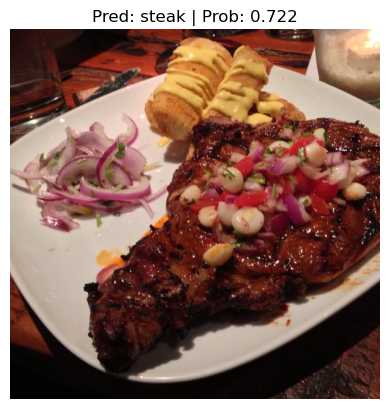

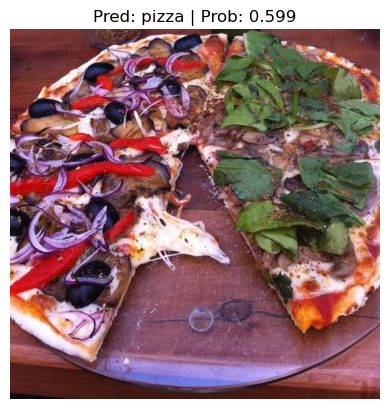

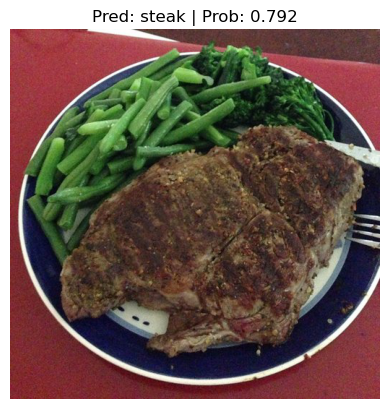

In [55]:
# Import function to make prediction on images and plot them
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path/"test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                      k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                       image_path=image_path,
                       class_names = class_names,
                       image_size=(224, 224))

In [56]:
torch.__version__

'2.0.0'